In [1]:
#import all the libraries
import os
import glob
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard

Using TensorFlow backend.


In [2]:
train_dir = 'data_64/train'
val_dir = 'data_64/val'
target_size = (64, 64)
batch_size = 64

In [3]:
def adjustData(img,mask):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

In [4]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                   num_class = 2,save_to_dir = None,target_size = target_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(shear_range=0.05,
                                       zoom_range=0.05,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    mask_datagen = ImageDataGenerator(shear_range=0.05,
                                      zoom_range=0.05,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        shuffle = True,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        shuffle = True,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

In [5]:
def validationGenerator(batch_size,validation_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                   mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                   num_class = 2,save_to_dir = None,target_size = target_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(shear_range=0.05,
                                       zoom_range=0.05,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    mask_datagen = ImageDataGenerator(shear_range=0.05,
                                      zoom_range=0.05,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
    
    image_generator = image_datagen.flow_from_directory(
        validation_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        shuffle = True,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        validation_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        shuffle = True,
        seed = seed)
    validation_generator = zip(image_generator, mask_generator)
    for (img,mask) in validation_generator:
        img,mask = adjustData(img,mask)
        yield (img,mask)

In [6]:
data_gen_args = dict(shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

In [7]:
train_data = trainGenerator(64, 'data_64/train', 'cxr_patches', 'mask_patches', data_gen_args, save_to_dir=None)

In [8]:
val_data = validationGenerator(64, 'data_64/val', 'cxr_patches', 'mask_patches', data_gen_args, save_to_dir=None)

In [9]:
def unet(input_size = (64,64,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs) #64X64X64
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1) #64X64X64
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #32X32X64

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1) #32X32X128
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2) #32X32X128
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #16X16X128

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2) #16X16X256
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3) #16X16X256
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #8X8X256

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3) #8X8X512
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4) #8X8X512
    drop4 = Dropout(0.5)(conv4) #8X8X512

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4)) #16X16X256
    merge5 = concatenate([conv3,up5], axis = 3) #16X16X512
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5) #16X16X256
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5) #16X16X256

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5)) #32X32X128
    merge6 = concatenate([conv2,up6], axis = 3) #32X32X256
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6) #32X32X128
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6) #32X32X128

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6)) #64X64X64
    merge7 = concatenate([conv1,up7], axis = 3) #64X64X128
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7) #64X64X64
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7) #64X64X64
    conv7 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7) #64X64X2

    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv7) #64X64X1

    model = Model(input = inputs, output = outputs)

    return model

In [10]:
model_checkpoint = ModelCheckpoint('lung_segmentation_64.hdf5', verbose=1, save_best_only=True)

In [11]:
# laod model and show the model summary
model = unet()
model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [12]:
model.fit_generator(train_data,
                    steps_per_epoch=92510//batch_size,
                    epochs=60,
                    validation_data=val_data,
                    validation_steps= 11774//batch_size,
                    callbacks=[model_checkpoint])

Epoch 1/60
Found 11774 images belonging to 1 classes.
Found 11774 images belonging to 1 classes.
Found 92510 images belonging to 1 classes.
Found 92510 images belonging to 1 classes.
1445/1445 [==============================] - 1973s 1s/step - loss: 0.3183 - acc: 0.8810 - val_loss: 0.2674 - val_acc: 0.9222

Epoch 00001: val_loss improved from inf to 0.26739, saving model to lung_segmentation_64.hdf5
Epoch 2/60
1445/1445 [==============================] - 723s 500ms/step - loss: 0.2719 - acc: 0.9271 - val_loss: 0.2569 - val_acc: 0.9270

Epoch 00002: val_loss improved from 0.26739 to 0.25694, saving model to lung_segmentation_64.hdf5
Epoch 3/60
1445/1445 [==============================] - 718s 497ms/step - loss: 0.2582 - acc: 0.9371 - val_loss: 0.2381 - val_acc: 0.9417

Epoch 00003: val_loss improved from 0.25694 to 0.23809, saving model to lung_segmentation_64.hdf5
Epoch 4/60
1445/1445 [==============================] - 721s 499ms/step - loss: 0.2470 - acc: 0.9471 - val_loss: 0.2377 - v

1445/1445 [==============================] - 719s 498ms/step - loss: 0.1549 - acc: 0.9835 - val_loss: 0.1544 - val_acc: 0.9776

Epoch 00038: val_loss improved from 0.15467 to 0.15437, saving model to lung_segmentation_64.hdf5
Epoch 39/60
1445/1445 [==============================] - 719s 498ms/step - loss: 0.1534 - acc: 0.9837 - val_loss: 0.1584 - val_acc: 0.9779

Epoch 00039: val_loss did not improve from 0.15437
Epoch 40/60
1445/1445 [==============================] - 717s 496ms/step - loss: 0.1507 - acc: 0.9842 - val_loss: 0.1567 - val_acc: 0.9769

Epoch 00040: val_loss did not improve from 0.15437
Epoch 41/60
1445/1445 [==============================] - 717s 496ms/step - loss: 0.1495 - acc: 0.9844 - val_loss: 0.1523 - val_acc: 0.9788

Epoch 00041: val_loss improved from 0.15437 to 0.15232, saving model to lung_segmentation_64.hdf5
Epoch 42/60
1445/1445 [==============================] - 721s 499ms/step - loss: 0.1479 - acc: 0.9844 - val_loss: 0.1523 - val_acc: 0.9775

Epoch 00042: v

#### Testing

In [13]:
def testGenerator(test_path, filenames):
    for file in filenames:
        #idx = str(i+1).zfill(5) + ".png"
        img = cv2.imread(os.path.join(test_path, file), 0)
        img = img / 255
        img = np.reshape(img, img.shape + (1,))
        img = np.reshape(img,(1,)+img.shape)
        yield img

In [25]:
import skimage.io as io

def saveResult(save_path, files):
    for i, item in enumerate(files):
        img = item[:,:,0]
        idx = str(i+1).zfill(5) + ".png"
        io.imsave(os.path.join(save_path, idx), img)

In [19]:
import random
test_dir = "data_64/test/cxr_patches"
files = os.listdir(test_dir)
random_files = random.sample(files, 20)
test_data = testGenerator(test_dir, random_files)

In [16]:
trained_model = load_model("lung_segmentation_64.hdf5")

In [26]:
results = trained_model.predict_generator(test_data, 20, verbose=1)

20/20 [==============================] - 0s 12ms/step


In [27]:
saveResult("data_64/test/outputs", results)

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\skimage\io\_io.py:141: UserWarning: data_64/test/outputs\00001.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\skimage\io\_io.py:141: UserWarning: data_64/test/outputs\00002.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\skimage\io\_io.py:141: UserWarning: data_64/test/outputs\00003.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\skimage

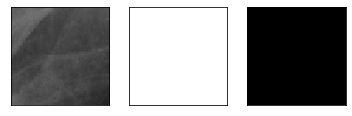

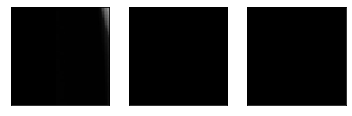

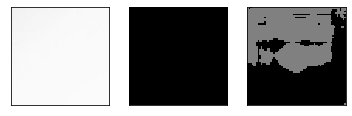

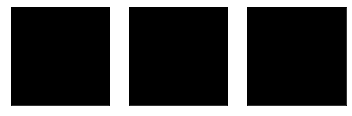

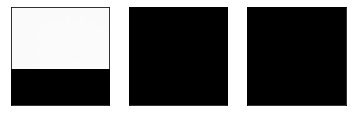

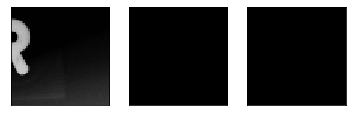

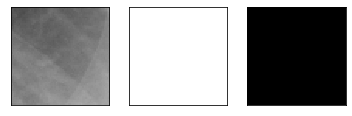

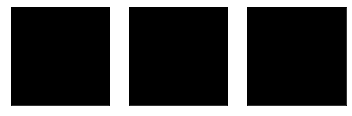

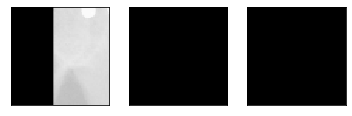

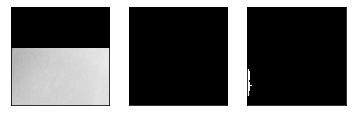

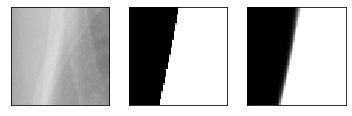

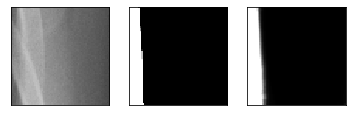

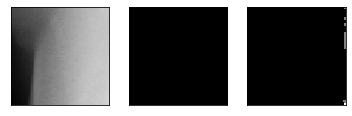

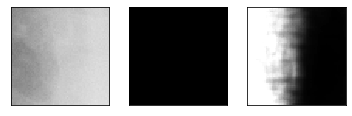

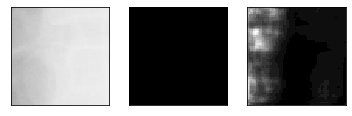

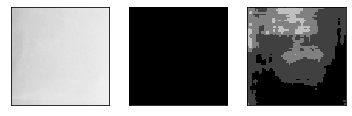

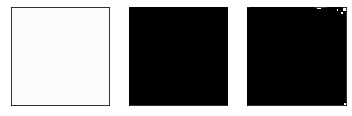

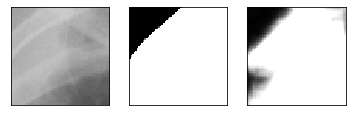

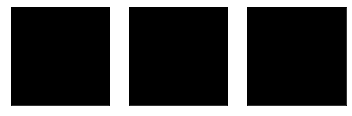

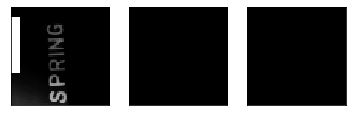

In [28]:
for i, file in enumerate(random_files):
    cxr_img_actual = cv2.imread(os.path.join("data_64/test/cxr_patches",file))
    cxr_mask_gt = cv2.imread(os.path.join("data_64/test/mask_patches",file))
    cxr_mask_predicted = (np.resize(results[i, :,:], (64, 64))*255).astype(np.uint8)

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(cxr_img_actual, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    
    axarr[1].imshow(cxr_mask_gt, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(cxr_mask_predicted, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([]) 
        
plt.show()

In [30]:
test_dir = "data_64/test"
cxr_test_dir = os.path.join(test_dir, "cxr")
mask_test_dir = os.path.join(test_dir, "mask")

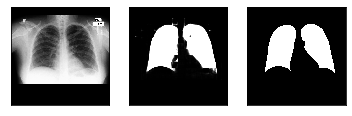

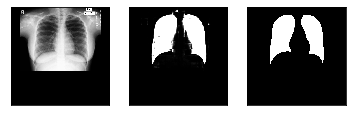

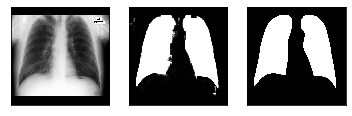

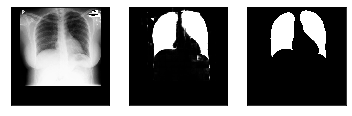

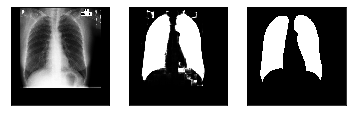

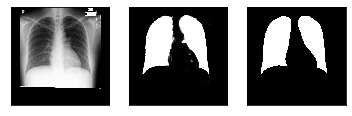

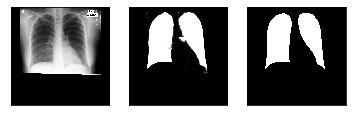

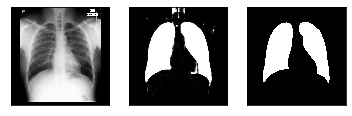

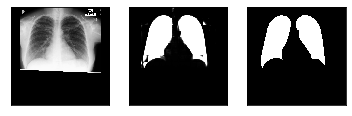

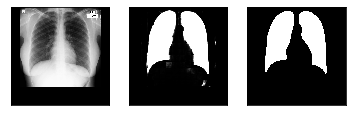

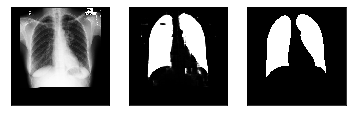

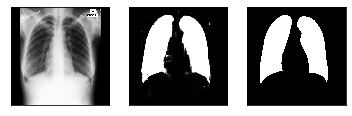

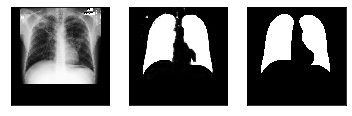

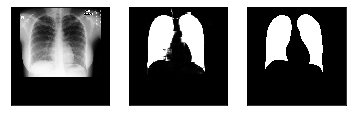

Average execution time:  0.7999941791806903


In [40]:
import time
#f = "MCUCXR_0001_0.png"
output_dir = "data_64/test/outputs"
total_time = 0
for file in os.listdir(cxr_test_dir):
    img = cv2.imread(os.path.join(cxr_test_dir, file), 0)/255
    mask = cv2.imread(os.path.join(mask_test_dir, file))
    predicted_mask = np.zeros(img.shape, dtype=np.uint8)

    start_time = time.time()
    for x in np.arange(0, 1024-64, 64):
        for y in np.arange(0, 1024-64, 64):
            # Crop 64 X 64 cxr and mask patches
            cxr_patch = img[x:x+64, y:y+64]
            cxr_patch = np.reshape(cxr_patch, cxr_patch.shape + (1,))
            cxr_patch = np.reshape(cxr_patch,(1,)+cxr_patch.shape)

            predicted_mask_patch = trained_model.predict(cxr_patch)
            predicted_mask_patch = (np.reshape(predicted_mask_patch, (64, 64))*255).astype(np.uint8)

            predicted_mask[x:x+64, y:y+64] = predicted_mask_patch

    elapsed_time = time.time() - start_time
    
    total_time = total_time+elapsed_time
    
    cv2.imwrite(os.path.join(output_dir, file), predicted_mask)
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img, cmap='gray')
    axarr[0].set_xticks([]), axarr[0].set_yticks([]) 
    
    axarr[1].imshow(predicted_mask, cmap='gray')
    axarr[1].set_xticks([]), axarr[1].set_yticks([]) 
    
    axarr[2].imshow(mask, cmap='gray')
    axarr[2].set_xticks([]), axarr[2].set_yticks([]) 
    

    #titles = ['Original Image', 'Initial Mask']
    #images = [img, mask]

    #plt.figure(figsize=(15,10))
    #for i in range(2):
        #plt.subplot(1,2,i+1)
        #plt.imshow(images[i],'gray')
        #plt.title(titles[i])
        #plt.xticks([]),plt.yticks([])
plt.show()  

print("Average execution time: ", (total_time/len(os.listdir(cxr_test_dir))))

In [39]:
print("Average execution time: ",total_time/len(os.listdir(cxr_test_dir)))

Average execution time:  0.7913515397480556
